# Text classification with Transformer

Se implementa un bloque Transformer como una capa Keras.

### Importar librerías

In [1]:
import keras
import pandas as pd
from keras import ops
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2024-12-16 02:16:38.558676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734326198.680101    6085 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734326198.721796    6085 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 02:16:40.024871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Implementar un Bloque Transformer como una Layer

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

### Implementar una Layer Embedding

Dos capas de embedding, una para tokens y otra para el índice de tokens (posiciones).

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

### Cargar el dataset

In [4]:
df = pd.read_csv("../dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,19821,19821
unique,19815,20
top,en cet article est partiellement ou en totalit...,Thai
freq,6,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [5]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
maxlen=300
vocab_size = 200000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=maxlen)
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 15, 17, 16,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (13874, 300) (13874,)
Validación: (1982, 300) (1982,)
Prueba: (3965, 300) (3965,)


### Construcción del Modelo Transformer

Creamos la arquitectura del modelo con las layers implementadas previamente de embedding y el bloque transformer. Se agrega una capa GlobalAveragePooling1D para promediar las salidas de la capa de salida del transformer. Finalmente, se agrega una capa densa con activación softmax para clasificar las etiquetas.

In [8]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

2024-12-16 02:16:54.871318: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-12-16 02:16:54.912109: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.
2024-12-16 02:16:54.937327: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.
2024-12-16 02:16:54.949915: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 300, 32)        │     6,409,600 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 300, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,421,336 (24.50 MB)

 Trainable params: 6,421,336 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

In [9]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val)
)

Epoch 1/10


2024-12-16 02:16:58.744051: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.
2024-12-16 02:16:58.874218: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


434/434 ━━━━━━━━━━━━━━━━━━━━ 110s 237ms/step - accuracy: 0.3142 - loss: 2.3235 - val_accuracy: 0.9803 - val_loss: 0.1141
Epoch 2/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 104s 240ms/step - accuracy: 0.9852 - loss: 0.0850 - val_accuracy: 0.9854 - val_loss: 0.0689
Epoch 3/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 97s 224ms/step - accuracy: 0.9979 - loss: 0.0199 - val_accuracy: 0.9869 - val_loss: 0.0658
Epoch 4/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 91s 209ms/step - accuracy: 0.9988 - loss: 0.0073 - val_accuracy: 0.9909 - val_loss: 0.0494
Epoch 5/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 94s 216ms/step - accuracy: 0.9995 - loss: 0.0064 - val_accuracy: 0.9919 - val_loss: 0.0540
Epoch 6/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 94s 218ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9864 - val_loss: 0.0848
Epoch 7/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 94s 217ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9929 - val_loss: 0.0540
Epoch 8/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 98s 226ms/step - accuracy: 0.9999 - loss: 9.3386e-04

### Evaluación del Modelo

In [10]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9897 - loss: 0.0787
Accuracy: 98.76%


### Guardar el modelo

In [11]:
model.save("../models/transformer_model.keras")

#### Precciones no acertadas

In [22]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

test_indices = X_test.indices if hasattr(X_test, 'indices') else df.index[-len(X_test):]
incorrect_predictions = []

for i, test_index in enumerate(test_indices):
    if y_pred[i] != y_test[i]:
        predicted_language = language_names[y_pred[i]]
        real_language = language_names[y_test[i]]
        incorrect_predictions.append({
            "Id": test_index,
            "Texto": decoded_texts[i],
            "Predicción": predicted_language,
            "Idioma Real": real_language
        })
        print(f"Id: {i} - Texto: {decoded_texts[i]} - Predicción: {predicted_language} - Idioma Real: {real_language}")

df = pd.DataFrame(incorrect_predictions)
df.to_csv('../results/transformer_incorrect_predictions.csv', index=False, encoding='utf-8')

124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step
Texto: سيد علي كويرات يوارى الثرى جريدة الخبر أونلاين الجزائر محمد علال ابريل سيد علي كويرات يا علي موت واقف جريدة البلاد الجزائرية
Predicción: Thai (Real: Arabic)

Texto: groot kronig bloem per steel de trompet is langer dan van de lengte van de bloemblaadjes maar niet langer dan de bloemblaadjes zelf
Predicción: Indonesian (Real: Dutch)

Texto: mandiri dbs uob standard bank nokia gramedia taman kenangan lestari trans yogi tang city agung lestari kota wisata era ray white pacific place city group mall gading mall kelapa gading sentral blok a tanah abang blok b tanah abang sudirman park spring hill
Predicción: Tamil (Real: Indonesian)

Texto: iv peatükis esitatakse teiste parteide suhtes rakendatava taktika põhimõtted programm lõpeb hüüdlausega
Predicción: Thai (Real: Estonian)

Texto: عالم القرون الوسطى الإيطالي إيكو بقوله
Predicción: Thai (Real: Arabic)

Texto: macshamhrain ut in historia wicklowa et societatis interdisciplinaris incepta de h

In [13]:
language_names = label_encoder.classes_
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=language_names))


Classification Report:
               precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       199
       Dutch       1.00      0.99      1.00       199
     English       0.97      0.98      0.98       200
    Estonian       1.00      0.97      0.99       200
      French       0.97      0.98      0.98       198
       Hindi       1.00      0.99      1.00       197
  Indonesian       0.98      0.99      0.99       194
      Korean       0.99      0.99      0.99       200
       Latin       0.98      0.97      0.98       190
     Persian       0.99      0.99      0.99       200
   Portugese       1.00      0.99      0.99       199
      Pushto       0.99      1.00      1.00       197
    Romanian       1.00      0.98      0.99       200
     Russian       0.99      0.98      0.99       200
     Spanish       1.00      0.97      0.99       199
     Swedish       1.00      1.00      1.00       197
       Tamil       0.97      0.99      0.98       196
  

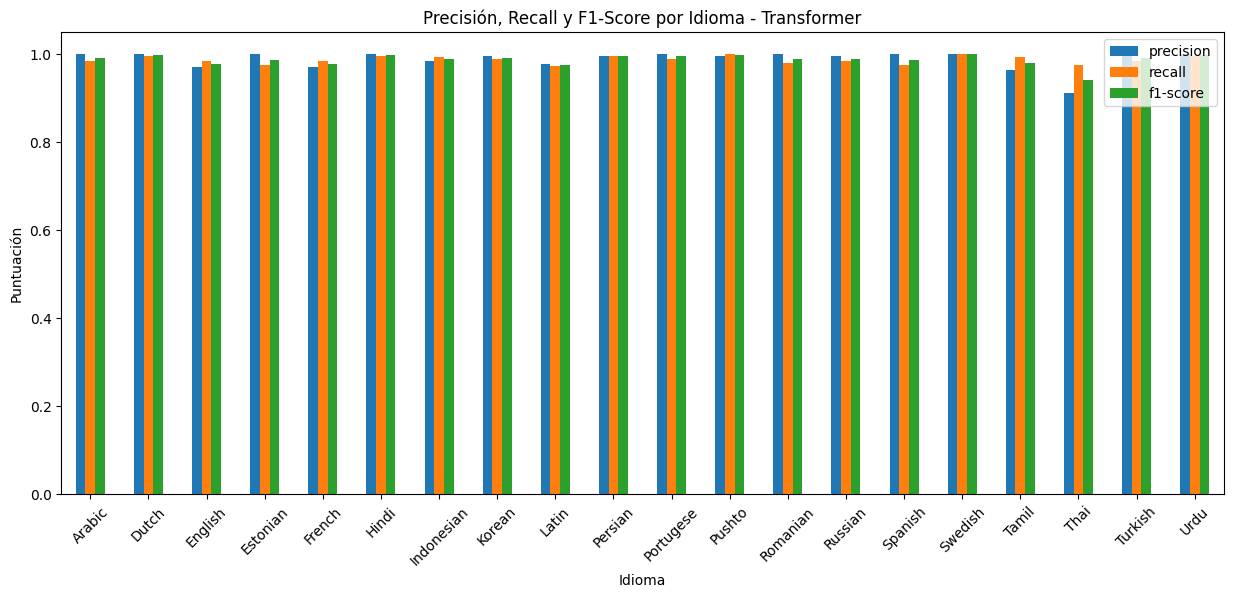

In [14]:
report_dict = classification_report(y_test, y_pred, target_names=language_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Precisión, Recall y F1-Score por Idioma - Transformer")
plt.ylabel("Puntuación")
plt.xlabel("Idioma")
plt.xticks(rotation=45)
plt.savefig("../plots/transformer_precision_recall_f1.png")
plt.show()

In [15]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Texto: hola este es un texto en español
Predicción: Spanish

Texto: hello this is a text in english
Predicción: English

Texto: bonjour ceci est un texte en français
Predicción: Romanian

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

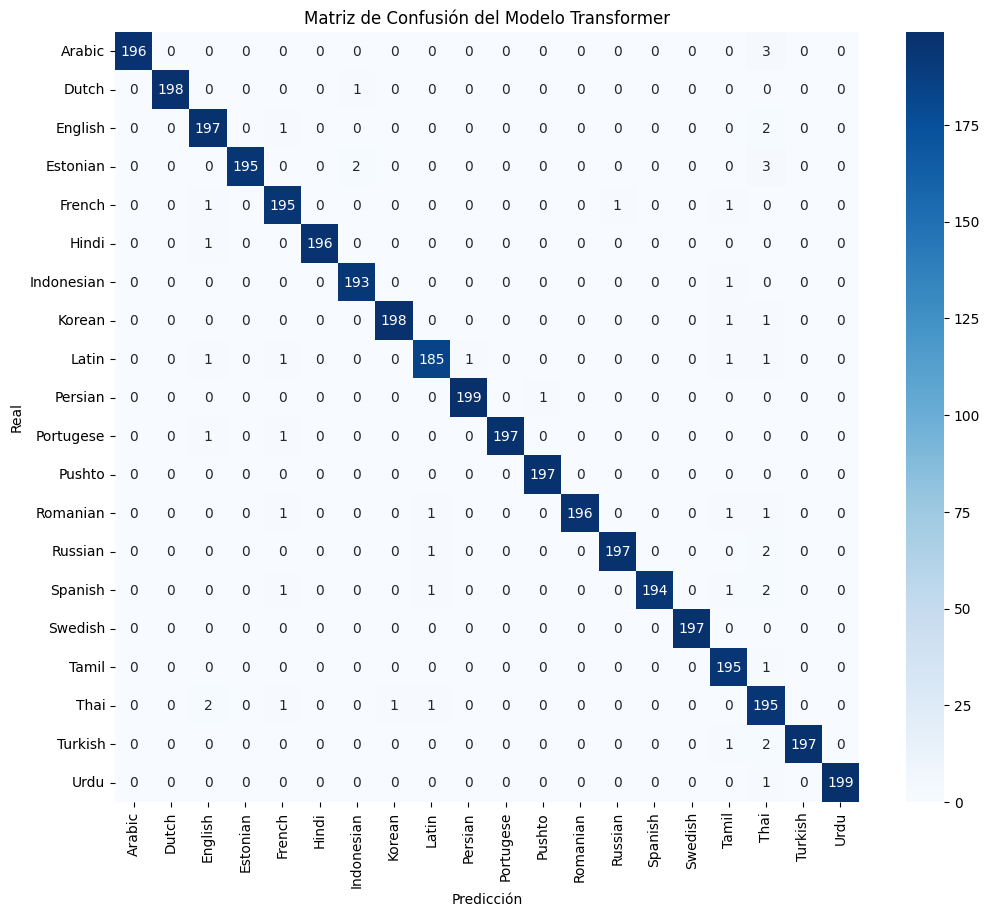

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo Transformer")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("../plots/transformer_confusion_matrix.png")
plt.show()

### Matriz de Confusión Normalizada

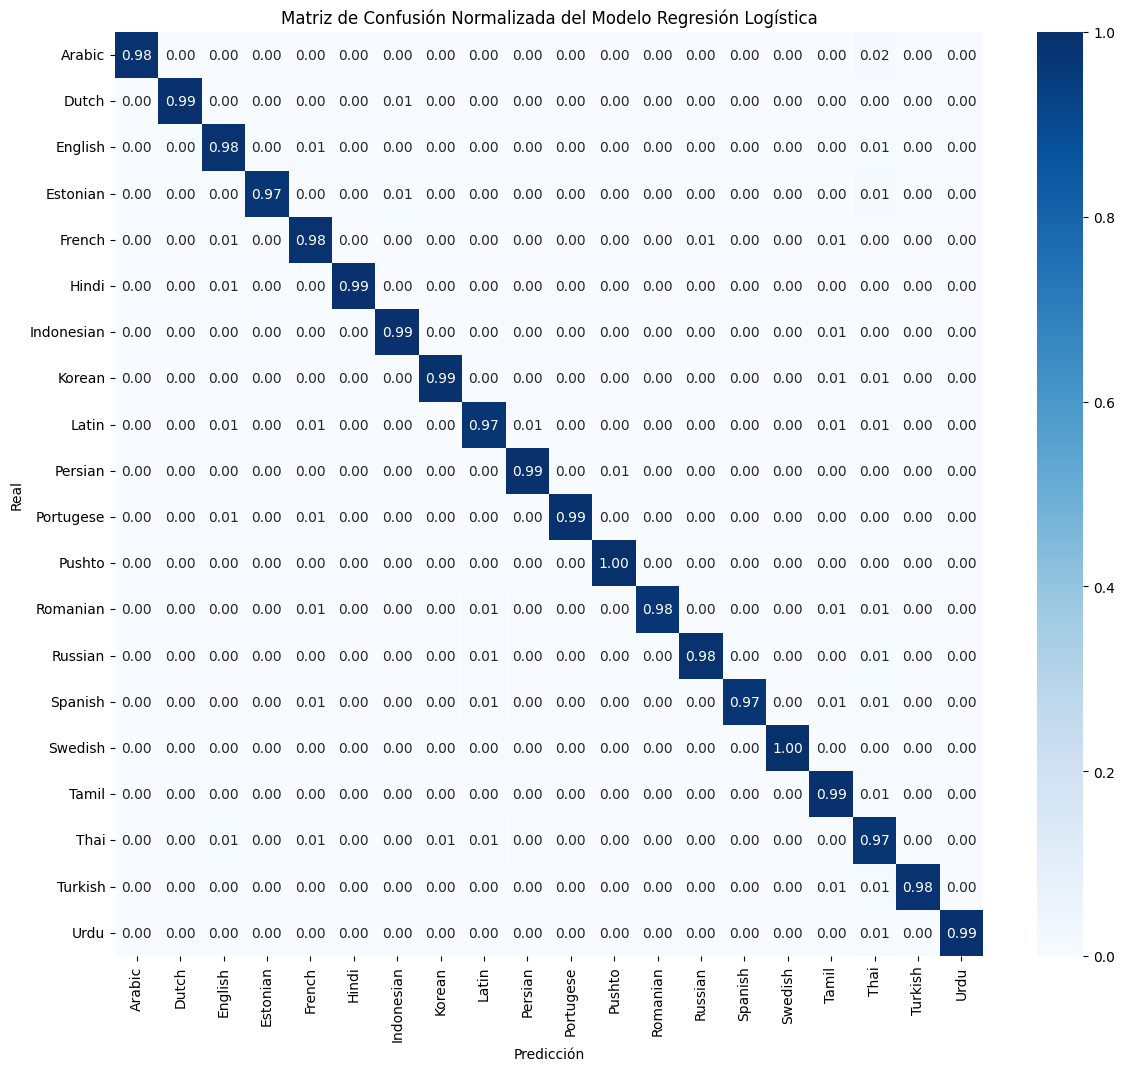

In [17]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión Normalizada del Modelo Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("../plots/transformer_confusion_matrix_normalized.png")
plt.show()

### Accuracy en Train y Validation

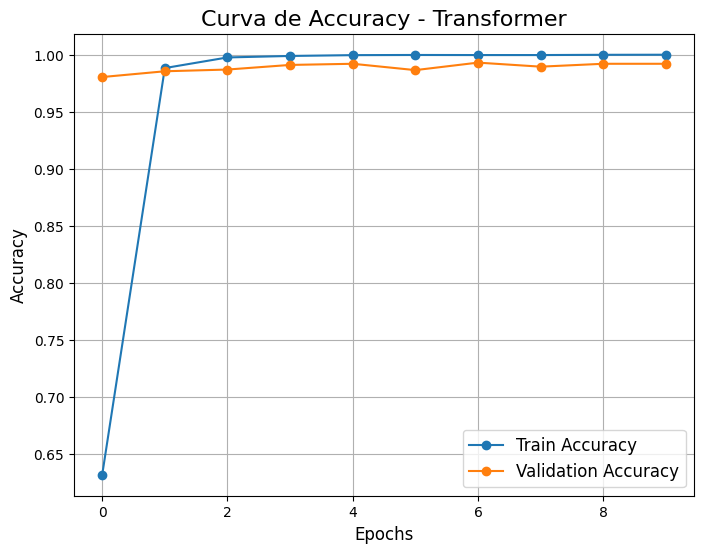

In [20]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy - Transformer', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("../plots/transformer_accuracy_curve.png")
plt.show()

### Loss en Train y Validation

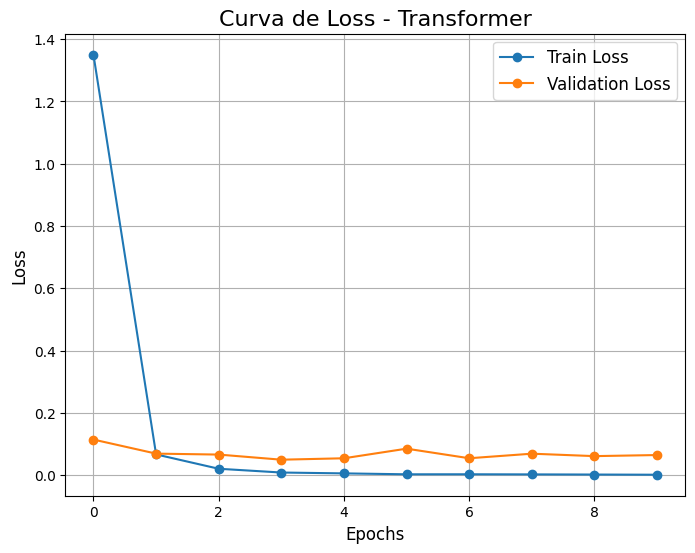

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss - Transformer', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("../plots/transformer_loss_curve.png")
plt.show()